# V647 Tau

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

First, let's take a look at the original light curve from the Kepler pipeline.

In [2]:
target = 'V647 Tau'

search = lk.search_lightcurve(target, cadence='short', mission='K2')
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,K2 Campaign 04,2015,K2,60,ktwo211072836,0.0


In [3]:
og_lc = search.download()

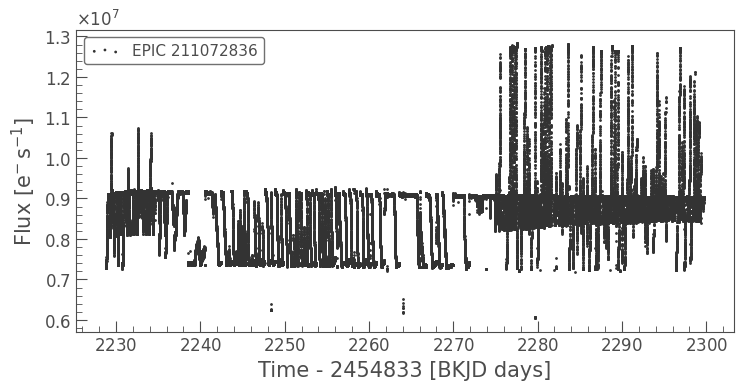

In [4]:
og_lc.scatter();

Not ideal. Zooming in:

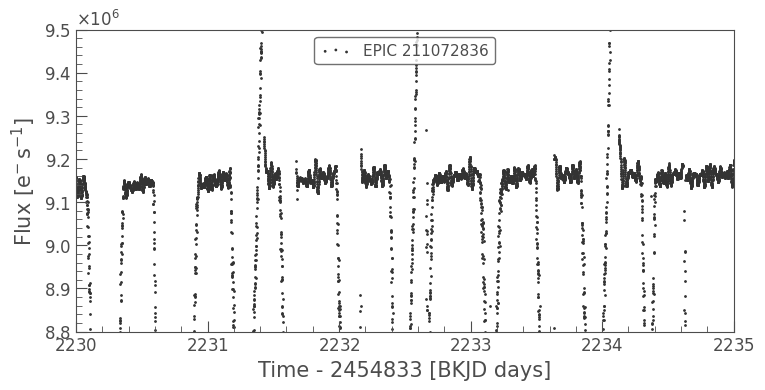

In [5]:
ax = og_lc.scatter()
ax.set_xlim(2230,2235)
ax.set_ylim(0.88e7,0.95e7);

We can see that there do appear to be stellar oscillations present, but the flux suddennly drops off or spikes, ruining the overall light curve. The reason why this happens can be seen once we look at the target pixel file.

In [6]:
search = lk.search_targetpixelfile(target, cadence='short', mission='K2')
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,K2 Campaign 04,2015,K2,60,ktwo211072836,0.0


In [7]:
tpf = search.download()

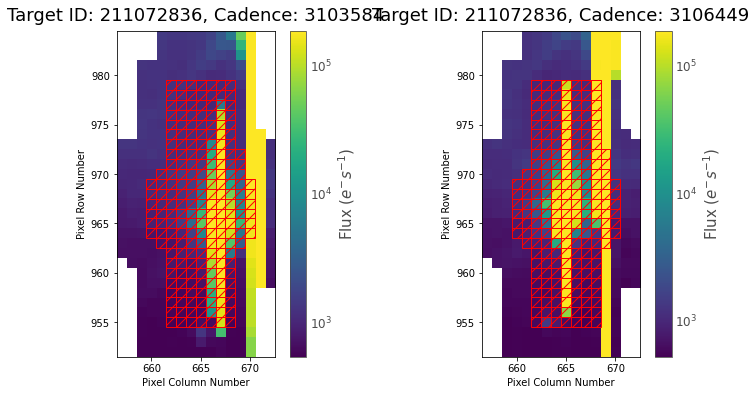

In [8]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
tpf[2794].plot(scale='log',aperture_mask=tpf.pipeline_mask, ax=ax1)
tpf[5656].plot(scale='log',aperture_mask=tpf.pipeline_mask, ax=ax2)
plt.show()

The bleed column of a bright nearby star - 24 Tau - enters the pipeline aperture mask and, as the pointing drifts, contributes more or less flux, leading to those sharp jumps in the light curve.

To overcome this, we can create a custom aperture mask that does not include any pixels that are never contaminated by the bleed column of 24 Tau:

In [9]:
mask1 = np.zeros((tpf[0].shape[1:]), dtype='bool')
mask1[14:16,6] = True
mask1[11:19,7] = True
mask1[4:29,8] = True
mask1[3:27,9] = True
mask1[11:20,10] = True

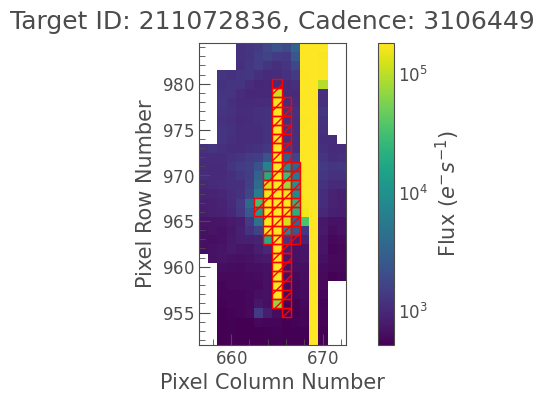

In [10]:
tpf[5656].plot(scale='log',aperture_mask=mask1);

However, doing so will create significant aperture losses from V647 Tau when the spacecraft motion is at the other extreme:

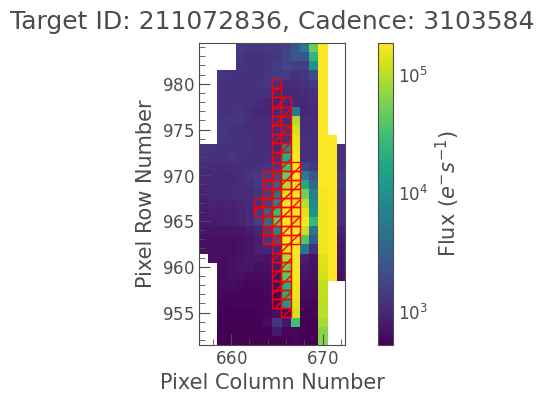

In [11]:
tpf[2794].plot(scale='log',aperture_mask=mask1);

A solution is to create two light curves using two different masks. One is affected by aperture losses from V647 Tau, and the other by the incursion of the bleed columns of 24 Tau. Then these two light curves can be merged to avoid both undesirable situations.

This mask will be affected by the bleed column, but not the aperture losses:

In [12]:
mask2 = np.zeros((tpf[0].shape[1:]), dtype='bool')
mask2[14:16,6] = True
mask2[11:19,7] = True
mask2[4:29,8] = True
mask2[3:27,9] = True
mask2[11:20,10] = True
mask2[13:18,11] = True

In [13]:
lc1 = tpf[:14251].to_lightcurve(aperture_mask = mask1)
lc2 = tpf[:14251].to_lightcurve(aperture_mask = mask2)

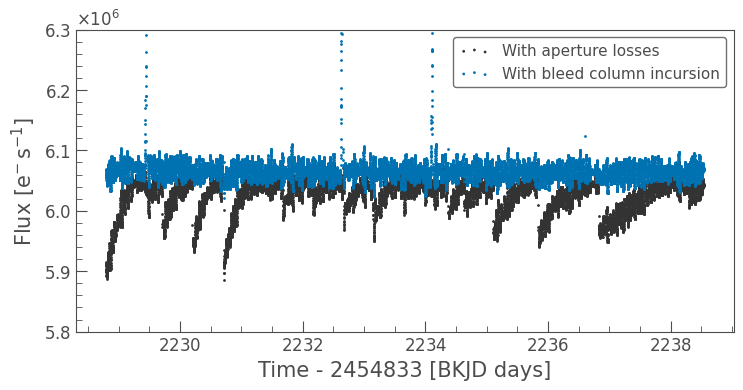

In [14]:
ax = lc1.scatter(label='With aperture losses')
lc2.scatter(ax=ax, label='With bleed column incursion')
ax.set_ylim(5.8e6,6.3e6);

To decide on where to make the transition, we can plot the flux as a function of the centroid column location of V647 Tau:

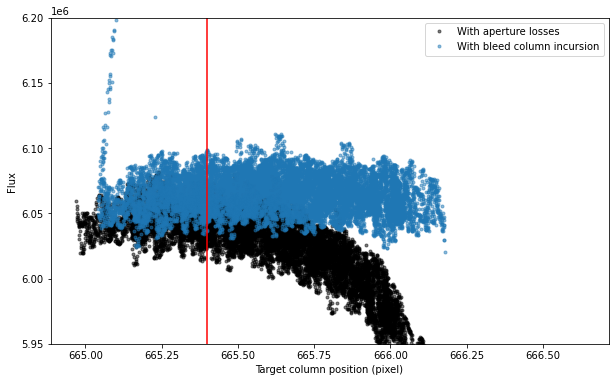

In [15]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

plt.plot(lc1.centroid_col,lc1.flux,'.',alpha=0.5, c='k', label='With aperture losses')
plt.plot(lc2.centroid_col,lc2.flux,'.',alpha=0.5, label='With bleed column incursion')
plt.ylim(5.95e6,6.2e6)
plt.xlabel('Target column position (pixel)')
plt.ylabel('Flux')
plt.axvline(665.4,c='r')
plt.legend()
plt.show()

To the left of the red line above, we can take the 'aperture loss' light curve where there are minimal aperture losses. To the right of the red line we can take the 'bleed column' light curve. To account for the different flux levels due to the different aperture sizes, we will also need to normalize the light curves when we merge:

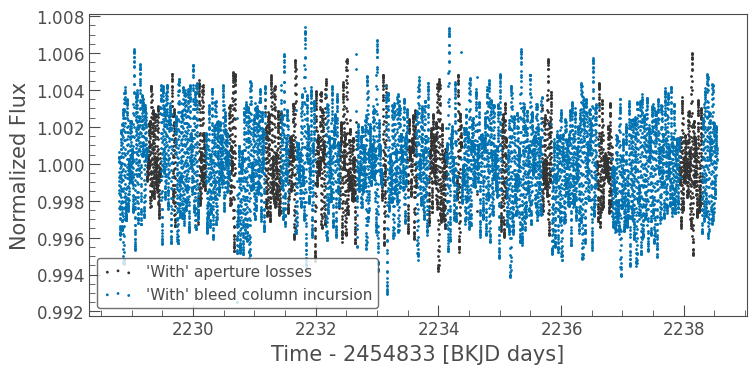

In [16]:
centroid_maskA = lc1.centroid_col.value > 665.4

ax = lc1[~centroid_maskA].normalize().scatter(label='\'With\' aperture losses')
lc2[centroid_maskA].remove_outliers().normalize().scatter(ax=ax, label='\'With\' bleed column incursion');

In [17]:
lcA = lc1[~centroid_maskA].normalize().append(lc2[centroid_maskA].remove_outliers().normalize())

This light curve now avoids both problems!

Finally, because the spacecraft roll motion changes throughout the campaign, the ideal aperture masks to use also change.

During the central segment of the observations, a single aperture mask can be found that is not signficantly affected by either problem:

In [18]:
mask3 = np.zeros((tpf[0].shape[1:]), dtype='bool')
mask3[14:17,7] = True
mask3[5:26,8] = True
mask3[3:27,9] = True
mask3[3:26,10] = True
mask3[13:18,11] = True

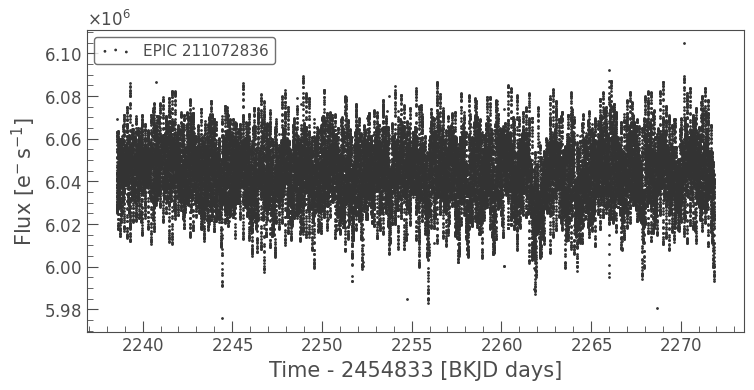

In [19]:
lc3 = tpf[14251:62809].to_lightcurve(aperture_mask = mask3)

lc3.remove_outliers().scatter();

However, for the final segment of the observations we again need to use two separate masks.

In [20]:
mask4 = np.zeros((tpf[0].shape[1:]), dtype='bool')
mask4[13:17,6] = True
mask4[8:22,7] = True
mask4[4:28,8] = True
mask4[2:27,9] = True
mask4[10:20,10] = True

In [21]:
mask5 = np.zeros((tpf[0].shape[1:]), dtype='bool')
mask5[14:16,6] = True
mask5[8:22,7] = True
mask5[4:28,8] = True
mask5[2:27,9] = True
mask5[10:20,10] = True
mask5[13:17,11] = True

In [22]:
lc4 = tpf[62809:].to_lightcurve(aperture_mask = mask4)
lc5 = tpf[62809:].to_lightcurve(aperture_mask = mask5)

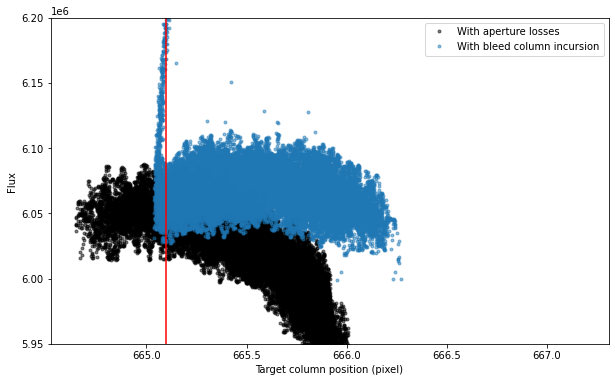

In [23]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

plt.plot(lc4.centroid_col,lc4.flux,'.',alpha=0.5, c='k', label='With aperture losses')
plt.plot(lc5.centroid_col,lc5.flux,'.',alpha=0.5, label='With bleed column incursion')
plt.ylim(5.95e6,6.2e6)
plt.xlabel('Target column position (pixel)')
plt.ylabel('Flux')
plt.axvline(665.1,c='r')
plt.legend()
plt.show()

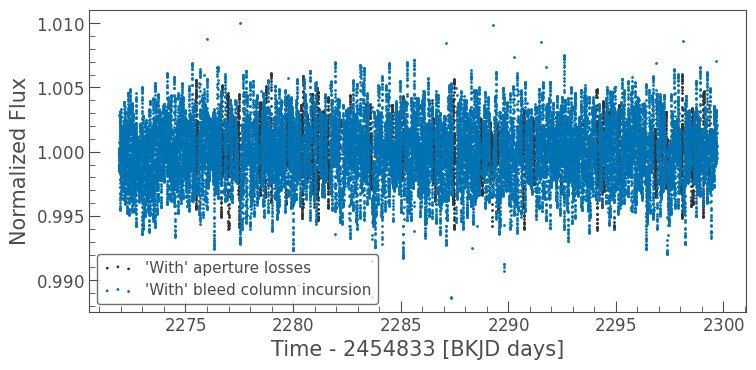

In [24]:
centroid_maskB = lc4.centroid_col.value > 665.1

ax = lc4[~centroid_maskB].normalize().scatter(label='\'With\' aperture losses')
lc5[centroid_maskB].remove_outliers().normalize().scatter(ax=ax, label='\'With\' bleed column incursion');

In [25]:
lcB = lc4[~centroid_maskB].normalize().append(lc5[centroid_maskB].remove_outliers().normalize())

Now we can make our final complete light curve:

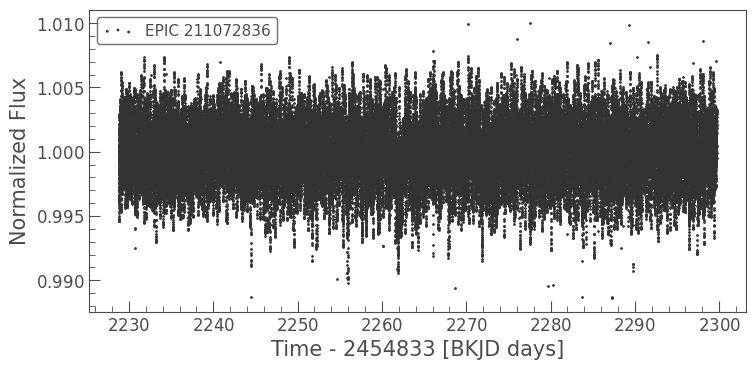

In [26]:
lc = lcA.append(lc3.remove_outliers().normalize()).append(lcB)
lc.scatter();

It's a significant improvemnt on the original!

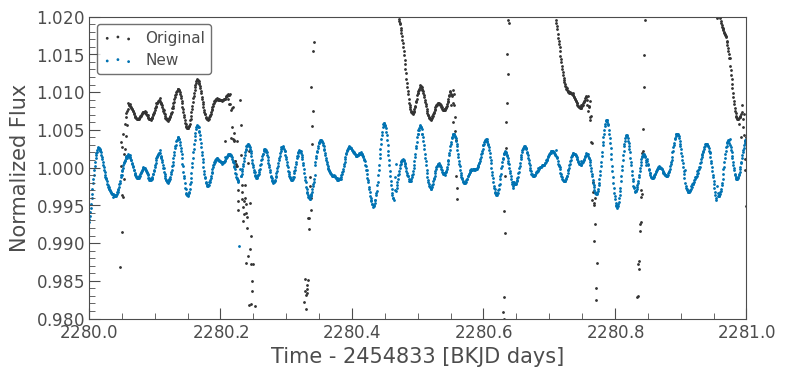

In [27]:
ax = og_lc.normalize().scatter(label='Original')
lc.scatter(ax=ax,label='New')
ax.set_ylim(0.98,1.02)
ax.set_xlim(2280,2281)
plt.show();

In [28]:
lc.to_csv(path_or_buf='../lightcurves/V647Tau_SC_C4_SYDSAP.csv')
lc.to_fits('../lightcurves/V647Tau_SC_C4_SYDSAP.fits')